<a href="https://colab.research.google.com/github/pihchikk/machine-learning-to-predict-the-oxidizaility-of-organic-carbon-in-surface-soil/blob/main/notebooks/models/Model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dependencies and imports

In [28]:
!pip install shap
!pip install phik
!pip install xgboost
!pip install -q catboost
!pip install scikit-learn
!pip install -q lightgbm==3.0

In [30]:
import os
import shap
import numpy as np
import pandas as pd
import seaborn as sns
from google.colab import drive
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.ensemble import (
    RandomForestRegressor,
    ExtraTreesRegressor,
    VotingRegressor,
)
from joblib import Parallel, delayed
from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    KFold,
)
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## Mount drive, upload data

In [31]:
drive.mount('/content/drive')
df = pd.read_excel('/content/drive/MyDrive/Tokarevka_data/Fieldpoints.xlsx')
df_b = df
df = df.drop('Biotopes_s', axis=1)
df = df.drop('rand_point', axis=1)
years_to_drop = ['2019', '2020', '2021', '2022', '2023'] #phenologivcal covariates are given yearly, thus all have a numeric index
df_nophen = df.drop(columns=[col for col in df.columns if any(year in col for year in years_to_drop)]) #separate dataset for non-phenological features

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Average values per each biotope type


In [32]:
average_values = df_b.groupby('Biotopes_s')[['hard_sh', 'med_sh', 'easy_sh']].mean()

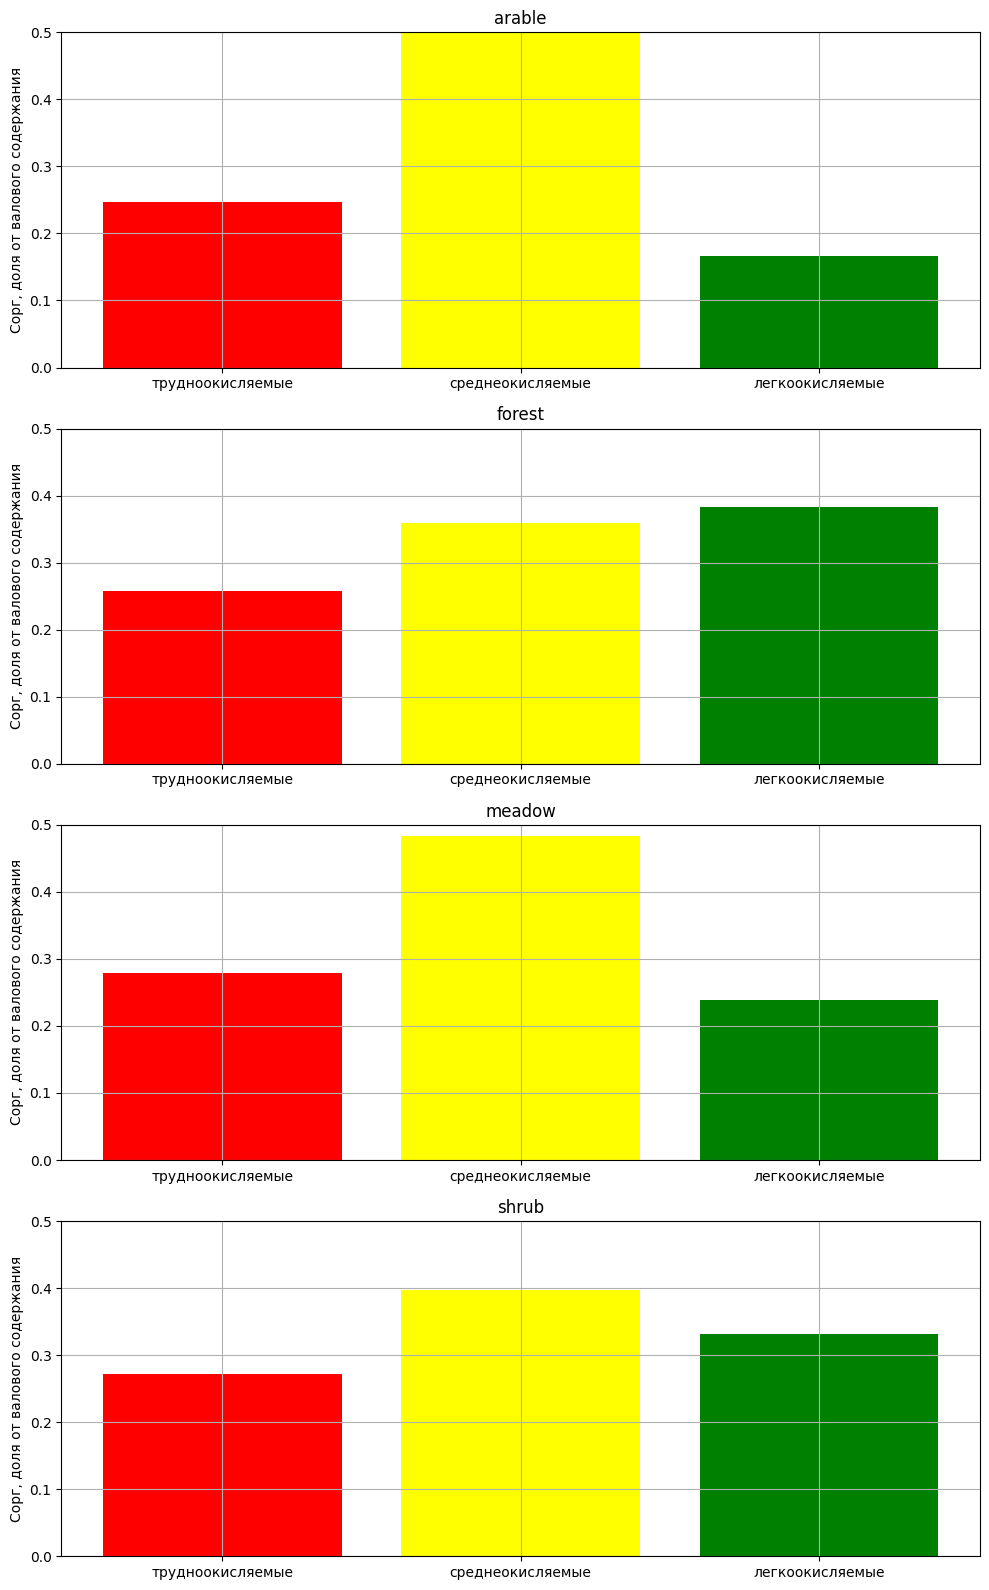

In [33]:
# Plotting
fig, axs = plt.subplots(4, 1, figsize=(10, 16))

for i, column in enumerate(average_values.T.columns):
    ax = axs[i]
    ax.bar(average_values.T.index, average_values.T[column], color=['red', 'yellow', 'green']) # Assigning different colors to each bar
    ax.set_ylabel('Сорг, доля от валового содержания')
    ax.set_xticks(['hard_sh', 'med_sh', 'easy_sh'],labels=['трудноокисляемые','среднеокисляемые','легкоокисляемые'])
    ax.set_xlabel('')
    ax.set_title(column)
    ax.grid(True)
    ax.set_ylim([0,0.5])

plt.tight_layout()
plt.show()


# Data preparation

## Separate X and Y

In [34]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def print_metrics(y_true, y_predicted):
    print(f"Mean squared error: {mean_squared_error(y_true, y_predicted):.3f}")
    print(
        "Root mean squared error: ",
        f"{mean_squared_error(y_true, y_predicted, squared=False):.3f}",
    )
    print(f"Mean absolute error: {mean_absolute_error(y_true, y_predicted):.3f}")
    print(f"R2 score: {r2_score(y_true, y_predicted):.3f}")
    print('\n')
def print_regression_equation(model, feature_names):
    intercept = model.intercept_
    coefficients = model.coef_
    equation = f"y = {intercept:.4f}"
    for coef, feature in zip(coefficients, feature_names):
        equation += f" + ({coef:.4f} * {feature})"
    print(equation)

In [40]:
df = df_nophen.dropna()

x = df.drop(['hard', 'med', 'easy', 'hard_sh', 'med_sh', 'easy_sh', 'sum'], axis=1)
x = x.dropna()

In [39]:
df_nophen.columns

Index(['hard', 'med', 'easy', 'sum', 'hard_sh', 'med_sh', 'easy_sh', 'pH_val',
       'TWI10m', 'TPI10m_1', 'Z10m_1', 'SOS21daily', 'SOS21_1', 'TRI10m_1',
       'PPI_aut1_P', 'slope10m_1', 'roughness1', 'Seasamp21_', 'SPI10m_1',
       'VRM10m_1', 'SprPPI1_PP', 'EOS21_1', 'Aspect10m_', 'MSAVIZ37N_',
       'NDWIZ37N_1', 'NDVIre3Z37', 'NDVIre1Z37', 'EVI2Z3N_1', 'BI2Z37N_1', 'X',
       'Y'],
      dtype='object')

## LinReg

Results for hard fraction:
Mean squared error: 0.020
Root mean squared error:  0.141
Mean absolute error: 0.093
R2 score: 0.816


----------------------------


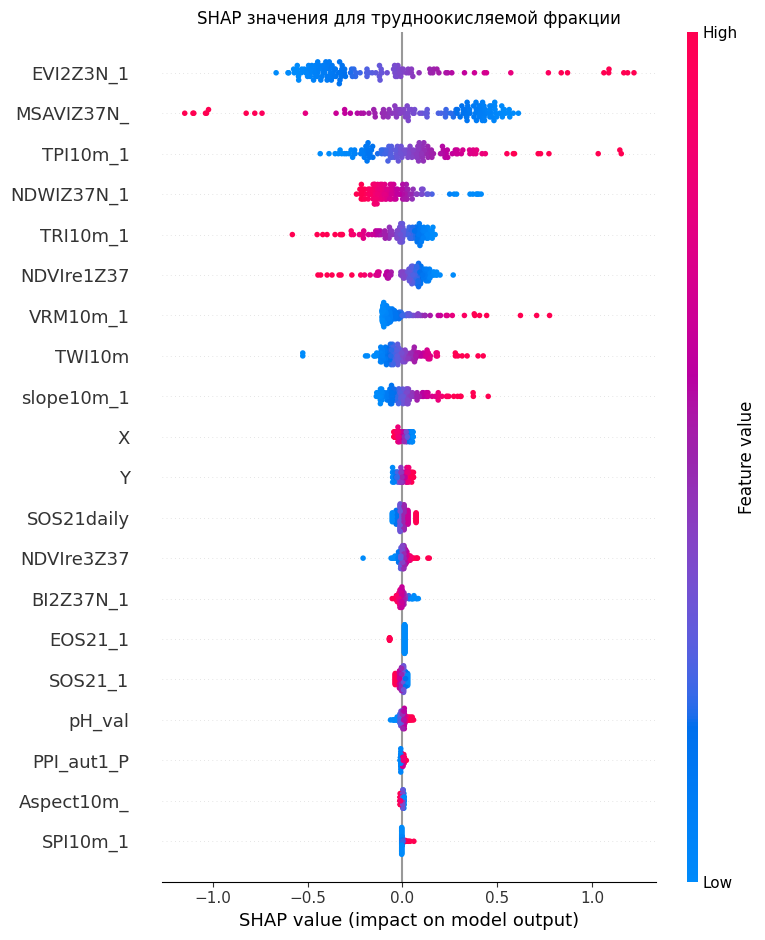

Results for med fraction:
Mean squared error: 0.048
Root mean squared error:  0.220
Mean absolute error: 0.181
R2 score: 0.480


----------------------------


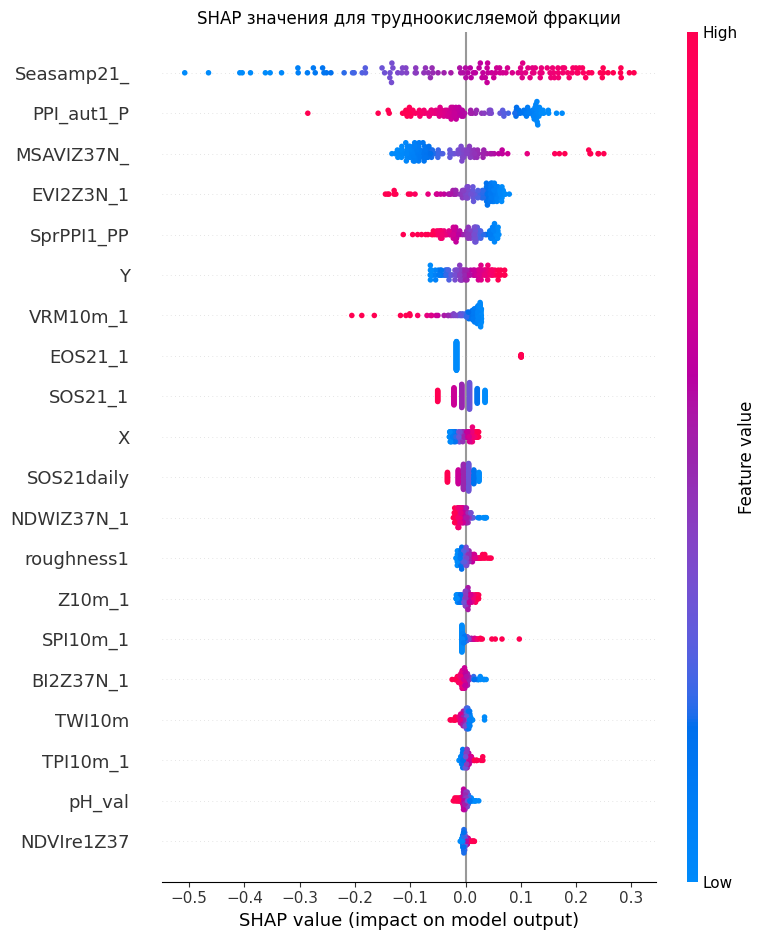

Results for easy fraction:
Mean squared error: 0.053
Root mean squared error:  0.231
Mean absolute error: 0.183
R2 score: 0.728


----------------------------


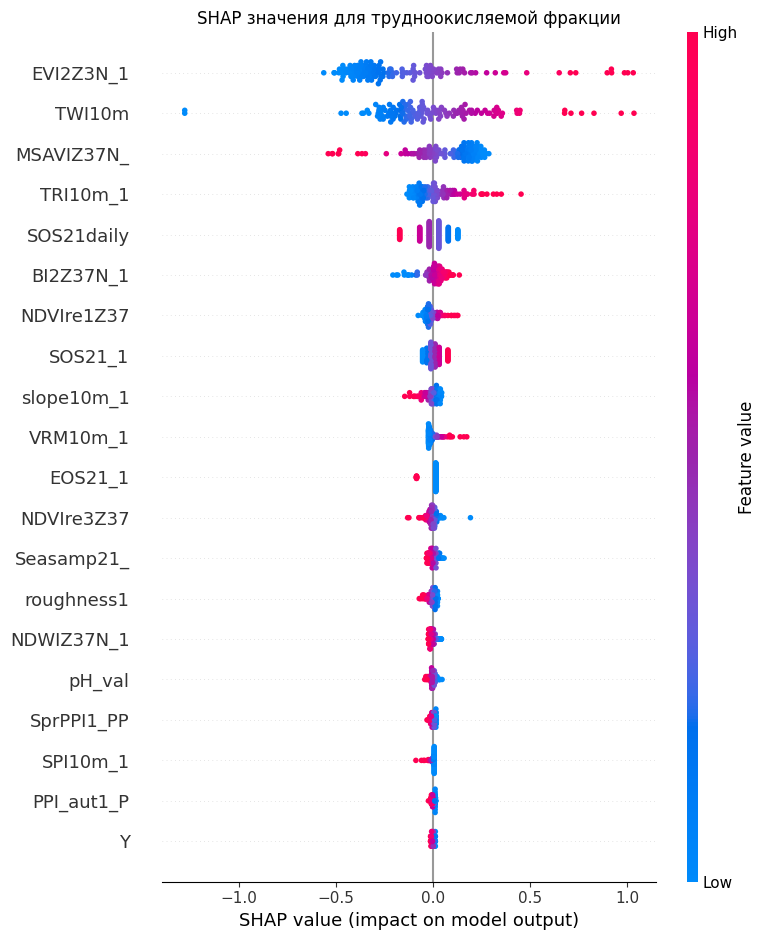

Results for sum fraction:
Mean squared error: 0.100
Root mean squared error:  0.316
Mean absolute error: 0.244
R2 score: 0.718


----------------------------


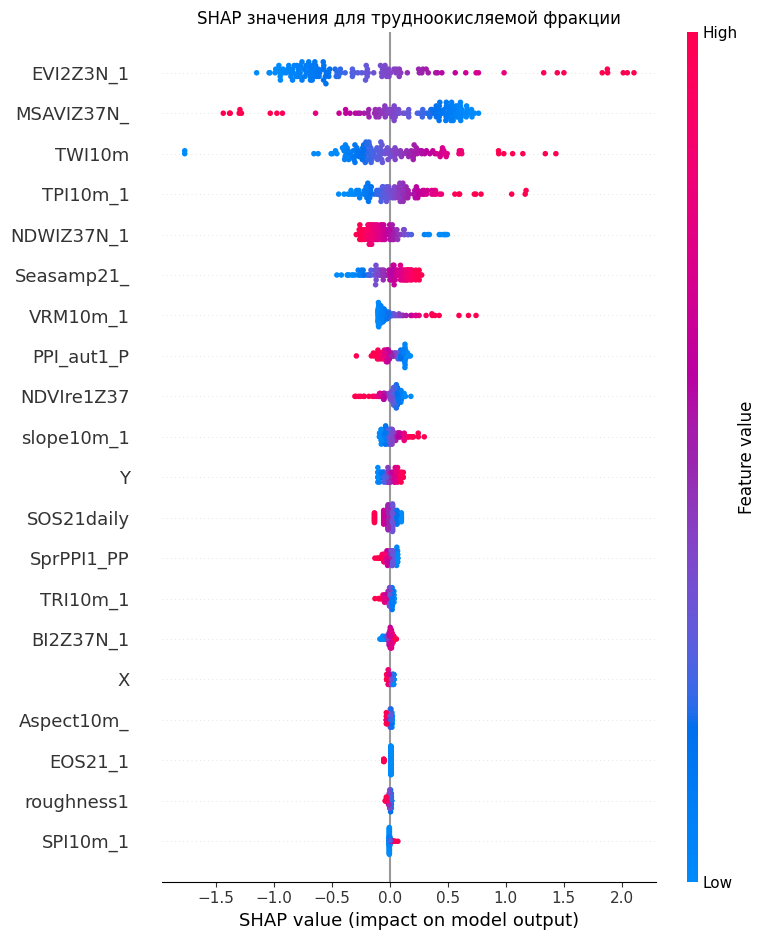

In [41]:
for fraction in ['hard', 'med', 'easy', 'sum']:
    y = df[fraction]
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.transform(x_test)

    regressor = LinearRegression()
    regressor.fit(x_train_scaled, y_train)

    y_pred = regressor.predict(x_test_scaled)

    print(f'Results for {fraction} fraction:')
    print_metrics(y_test, y_pred)
    print('----------------------------')

    explainer = shap.LinearExplainer(regressor, x_train_scaled)
    shap_values = explainer.shap_values(x_test_scaled)

    plt.title(f'SHAP значения для трудноокисляемой фракции')

    shap.summary_plot(shap_values, x_test_scaled, feature_names=x.columns)
    plt.show()

## RF

Metrics for hard fraction:
Mean squared error: 0.061
Root mean squared error:  0.247
Mean absolute error: 0.092
R2 score: 0.438




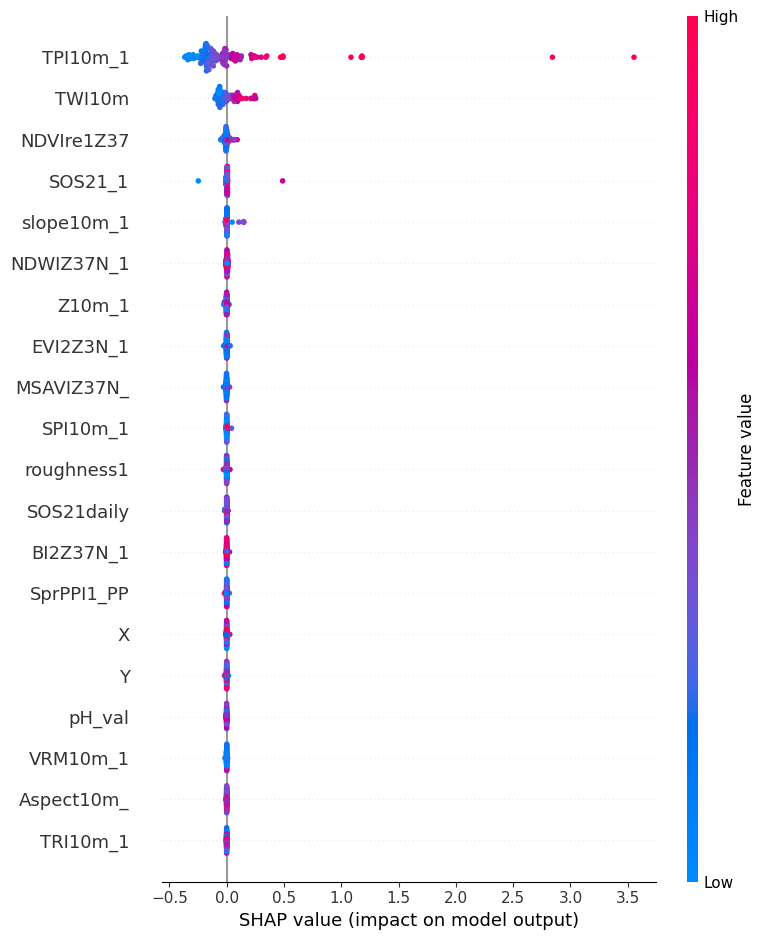

Metrics for med fraction:
Mean squared error: 0.091
Root mean squared error:  0.301
Mean absolute error: 0.235
R2 score: 0.027




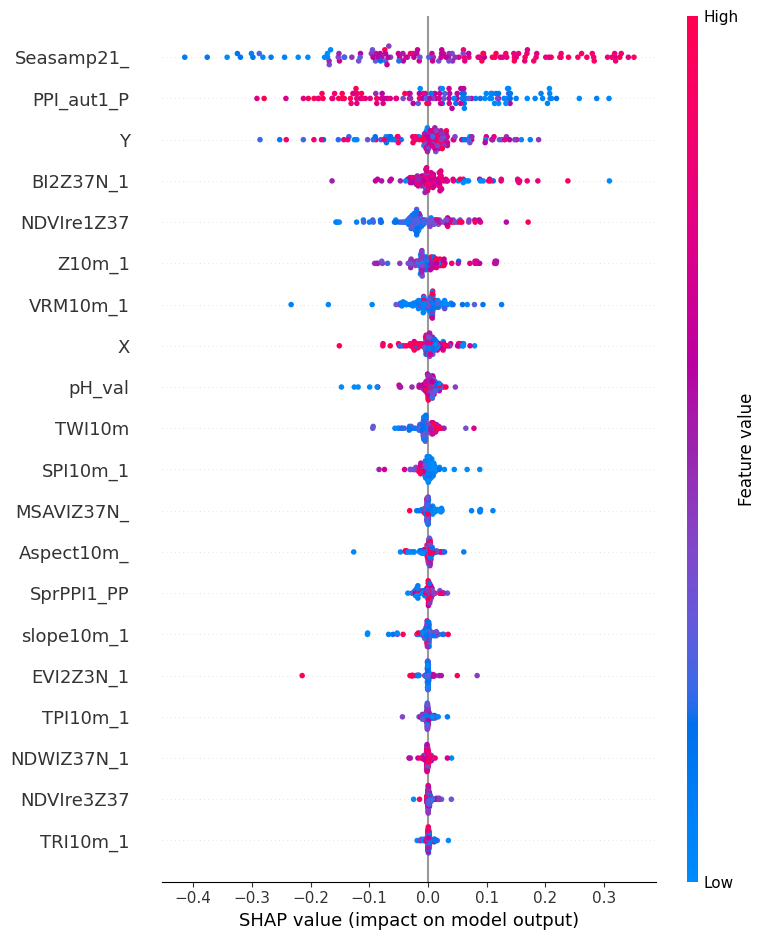

Metrics for easy fraction:
Mean squared error: 0.101
Root mean squared error:  0.318
Mean absolute error: 0.256
R2 score: 0.484




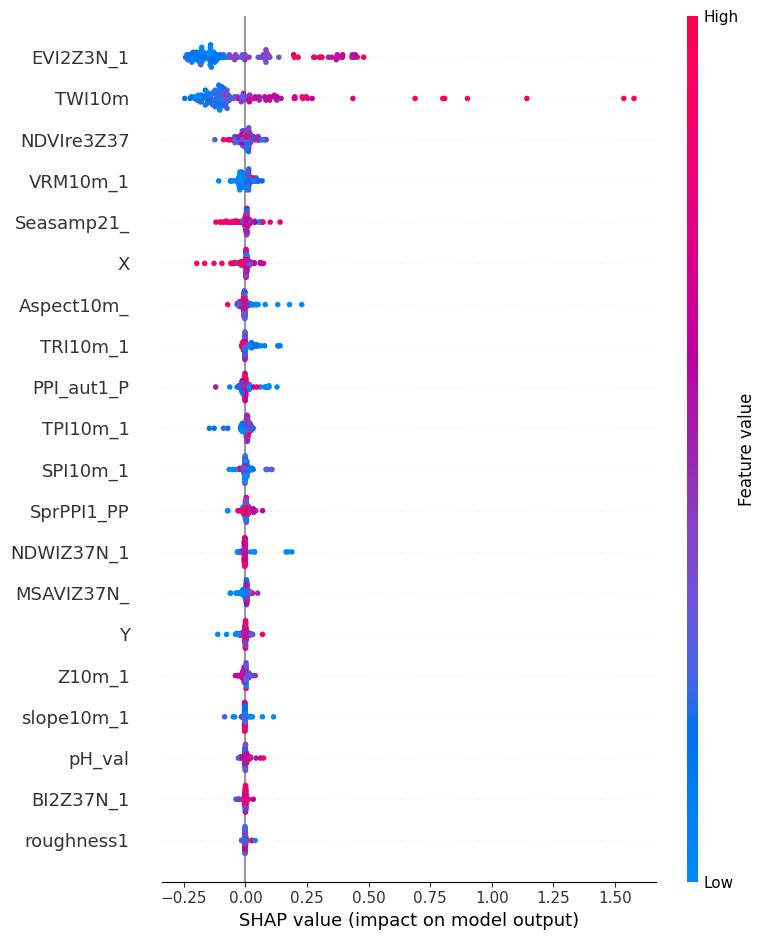

Metrics for sum fraction:
Mean squared error: 0.411
Root mean squared error:  0.641
Mean absolute error: 0.446
R2 score: -0.157




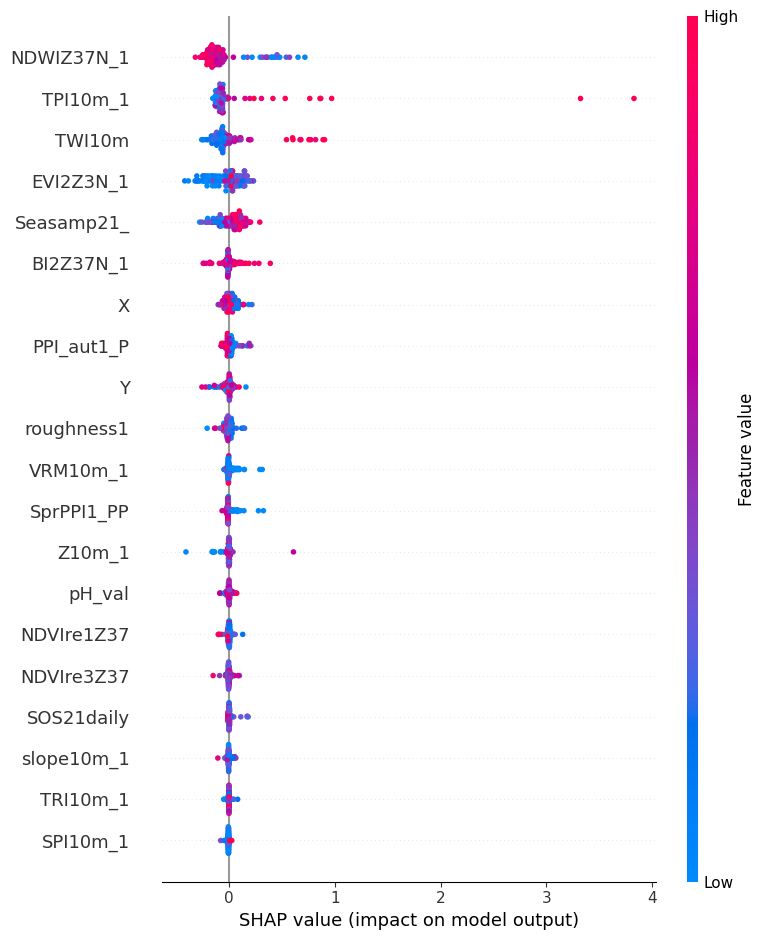

In [42]:
for fraction in ['hard', 'med', 'easy', 'sum']:
    y = df[fraction]
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.transform(x_test)

    regressor = DecisionTreeRegressor()
    regressor.fit(x_train_scaled, y_train)

    y_pred = regressor.predict(x_test_scaled)

    print(f"Metrics for {fraction} fraction:")
    print_metrics(y_test, y_pred)

    explainer = shap.TreeExplainer(regressor)
    shap_values = explainer.shap_values(x_test_scaled)

    shap.summary_plot(shap_values, x_test_scaled, feature_names=x.columns)

    shap.initjs()
    shap.force_plot(explainer.expected_value, shap_values[0,:], x_test_scaled[0,:], feature_names=x.columns)

plt.show()

## CatBoost

(425, 60) (425,)
Metrics for hard fraction:
Mean squared error: 0.011
Root mean squared error:  0.105
Mean absolute error: 0.056
R2 score: 0.898




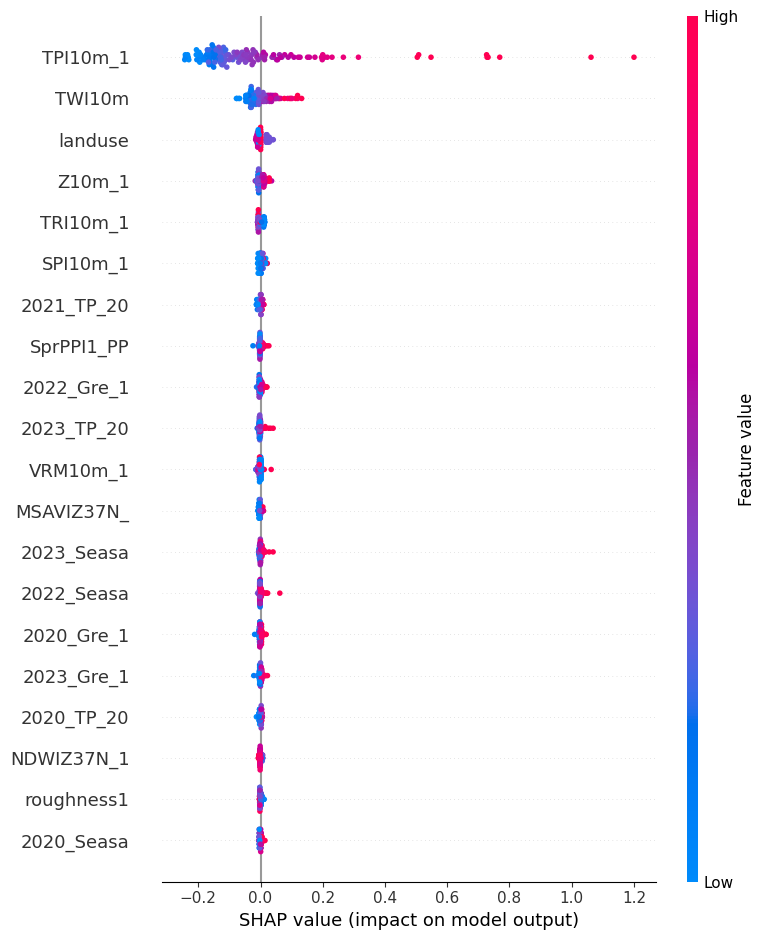

(425, 60) (425,)
Metrics for med fraction:
Mean squared error: 0.019
Root mean squared error:  0.136
Mean absolute error: 0.105
R2 score: 0.801




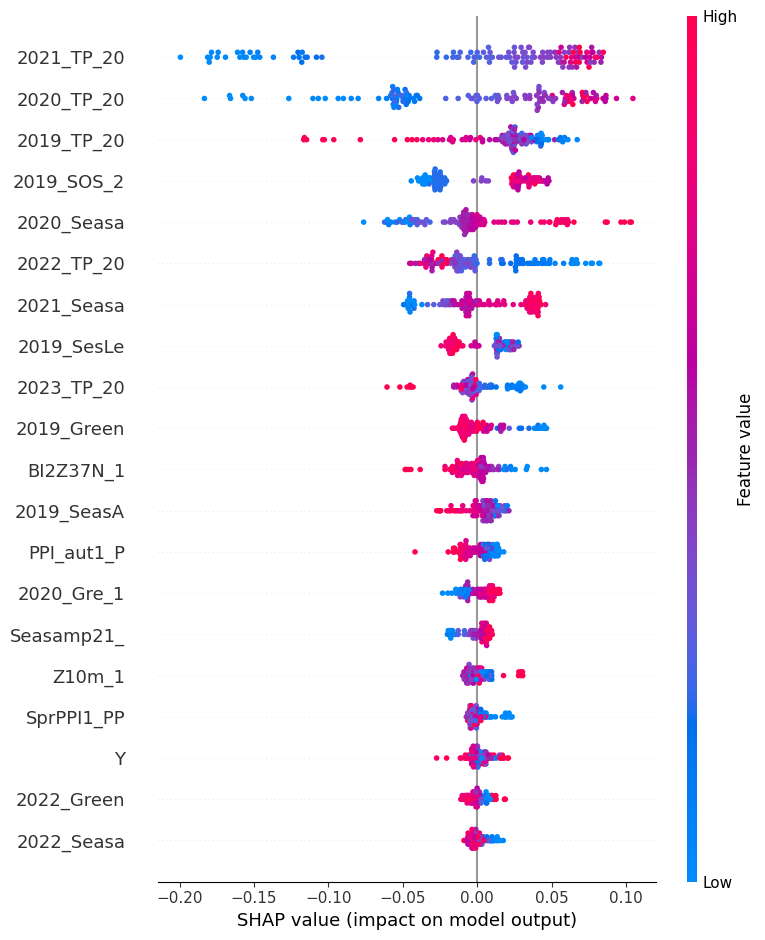

(425, 60) (425,)
Metrics for easy fraction:
Mean squared error: 0.078
Root mean squared error:  0.279
Mean absolute error: 0.207
R2 score: 0.601




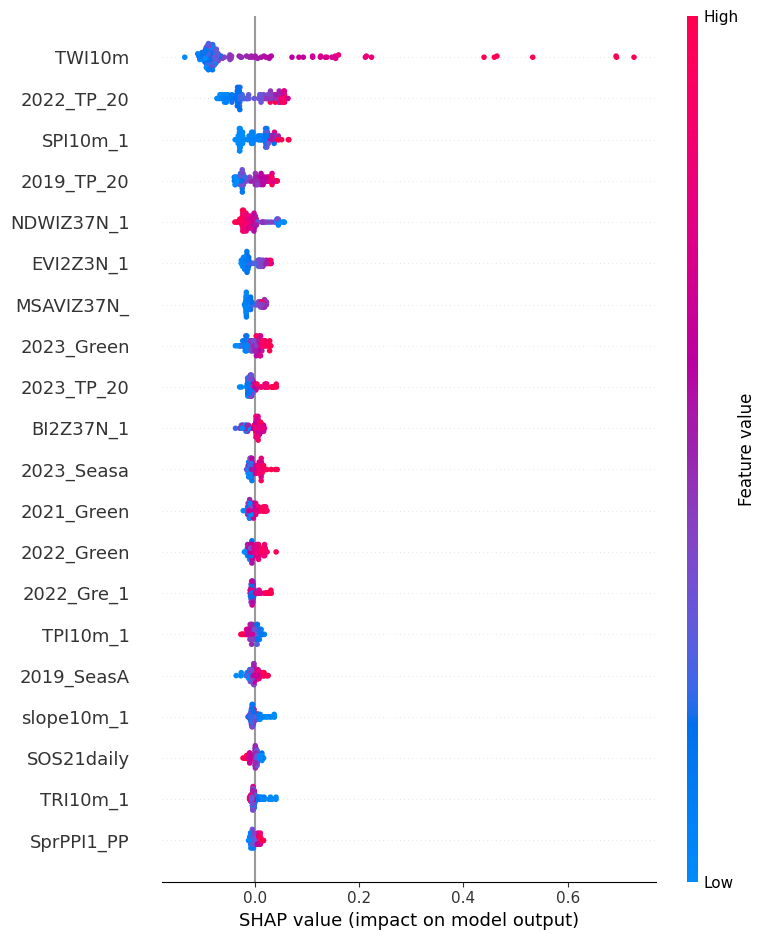

(425, 60) (425,)
Metrics for sum fraction:
Mean squared error: 0.117
Root mean squared error:  0.341
Mean absolute error: 0.241
R2 score: 0.671




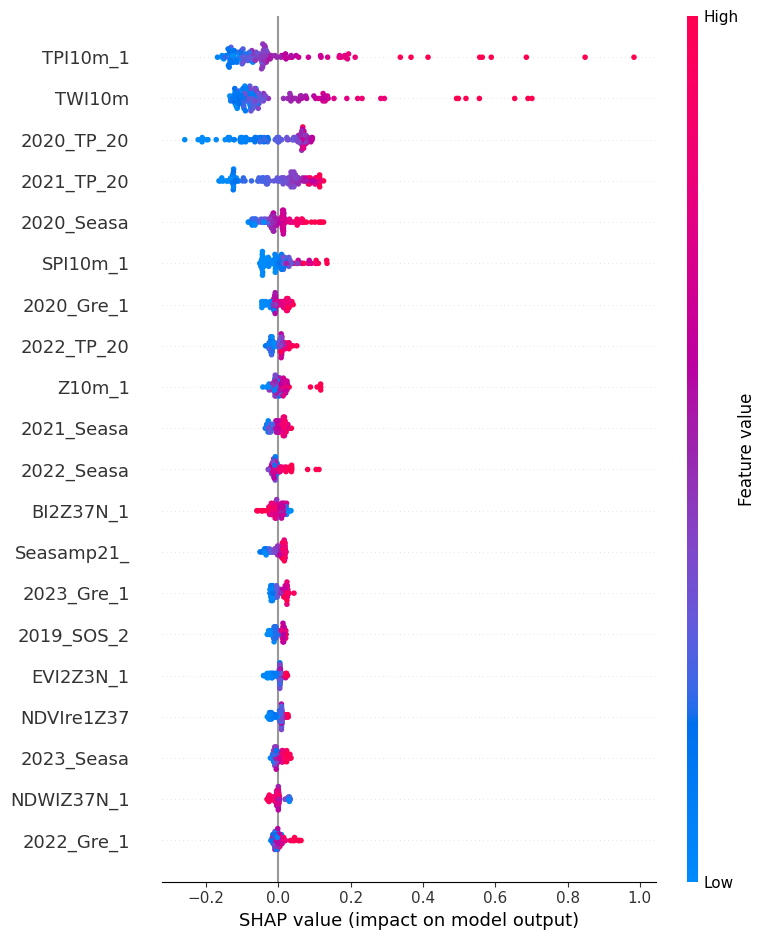

In [45]:
import matplotlib.pyplot as plt
import os
import pandas as pd

df = pd.read_excel('/content/drive/MyDrive/Tokarevka_data/Fieldpoints.xlsx')
df=df.drop('rand_point', axis=1)
df = df.dropna()
x = df.drop(['hard', 'med', 'easy', 'hard_sh', 'med_sh', 'easy_sh', 'sum'], axis=1)
x = x.dropna()

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import shap
import matplotlib.pyplot as plt

q1 = df['TPI10m_1'].quantile(0.25)
q3 = df['TPI10m_1'].quantile(0.75)

def assign_biotope(tpi):
    if tpi <= q1:
        return 'grass'
    elif tpi <= df['TPI10m_1'].median():
        return 'arable'
    elif tpi <= q3:
        return 'shrub'
    else:
        return 'forest'

def assign_biotope(tpi):
    if tpi <= q1:
        return 'grass'
    elif tpi <= df['TPI10m_1'].median():
        return 'arable'
    elif tpi <= q3:
        return 'shrub'
    else:
        return 'forest'

df['landuse'] = df['TPI10m_1'].apply(assign_biotope)
x['landuse'] = df['landuse'].astype('category').cat.codes
x['Biotopes_s'] = df['Biotopes_s'].astype('category').cat.codes

years_to_drop = ['2019', '2020', '2021', '2022', '2023']
df_nophen = df.drop(columns=[col for col in df.columns if any(year in col for year in years_to_drop)])


for fraction in ['hard', 'med', 'easy', 'sum']:
    y = df[fraction]
    print(x.shape,y.shape)
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = CatBoostRegressor(verbose=0)

    model.fit(X_train_scaled, y_train)

    y_pred = model.predict(X_test_scaled)

    print(f"Metrics for {fraction} fraction:")
    print_metrics(y_test, y_pred)

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test_scaled)

    shap.summary_plot(shap_values, X_test_scaled, feature_names=x.columns)

plt.show()

## Bootstrapping for uncertainty analysis

Fitting LR
Fitting PLSR
Fitting RF
Fitting CB
Fitting Тюнинг CB
0:	learn: 0.4070054	total: 1.66ms	remaining: 2.15s
500:	learn: 0.0486313	total: 588ms	remaining: 939ms
1000:	learn: 0.0227567	total: 1.17s	remaining: 349ms
1299:	learn: 0.0165754	total: 1.51s	remaining: 0us
Calculating bootstrap score for Cреднее по биотопам
Calculating bootstrap score for LR
Calculating bootstrap score for PLSR
Calculating bootstrap score for RF
Calculating bootstrap score for CB
Calculating bootstrap score for Тюнинг CB


<ipython-input-50-5035c0af3332>:154: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='model', y='mse', data=results_mse, ax=axes[0], palette="Set3")
<ipython-input-50-5035c0af3332>:160: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='model', y='r2', data=results_r2, ax=axes[1], palette="Set3")


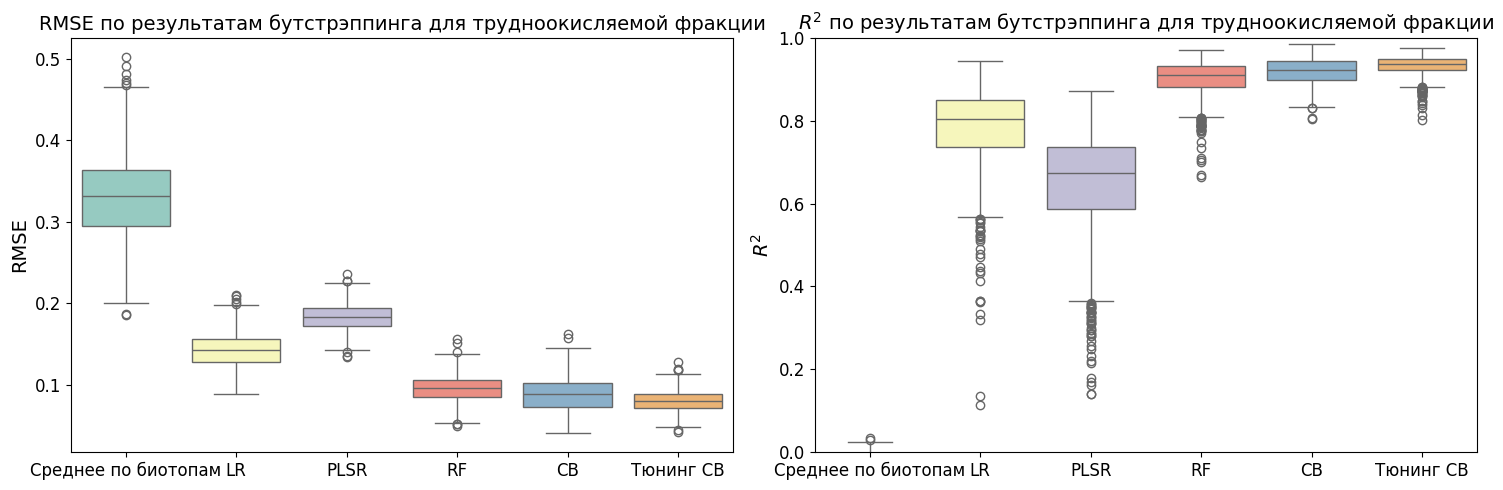

Fitting LR
Fitting PLSR
Fitting RF
Fitting CB
Fitting Тюнинг CB
0:	learn: 0.2941764	total: 1.3ms	remaining: 1.7s
500:	learn: 0.1397446	total: 573ms	remaining: 914ms
1000:	learn: 0.0875282	total: 1.18s	remaining: 352ms
1299:	learn: 0.0672080	total: 1.52s	remaining: 0us
Calculating bootstrap score for Cреднее по биотопам
Calculating bootstrap score for LR
Calculating bootstrap score for PLSR
Calculating bootstrap score for RF
Calculating bootstrap score for CB
Calculating bootstrap score for Тюнинг CB


<ipython-input-50-5035c0af3332>:154: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='model', y='mse', data=results_mse, ax=axes[0], palette="Set3")
<ipython-input-50-5035c0af3332>:160: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='model', y='r2', data=results_r2, ax=axes[1], palette="Set3")


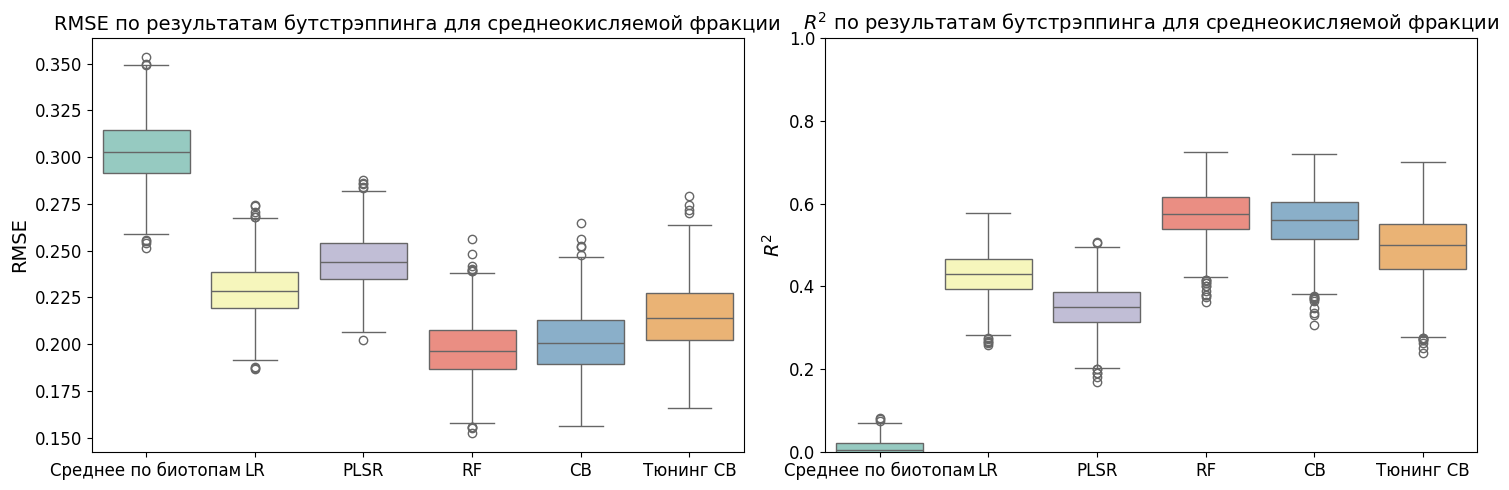

Fitting LR
Fitting PLSR
Fitting RF
Fitting CB
Fitting Тюнинг CB
0:	learn: 0.3670880	total: 1.23ms	remaining: 1.6s
500:	learn: 0.1211225	total: 564ms	remaining: 900ms
1000:	learn: 0.0795998	total: 1.16s	remaining: 345ms
1299:	learn: 0.0638743	total: 1.5s	remaining: 0us
Calculating bootstrap score for Cреднее по биотопам
Calculating bootstrap score for LR
Calculating bootstrap score for PLSR
Calculating bootstrap score for RF
Calculating bootstrap score for CB
Calculating bootstrap score for Тюнинг CB


<ipython-input-50-5035c0af3332>:154: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='model', y='mse', data=results_mse, ax=axes[0], palette="Set3")
<ipython-input-50-5035c0af3332>:160: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='model', y='r2', data=results_r2, ax=axes[1], palette="Set3")


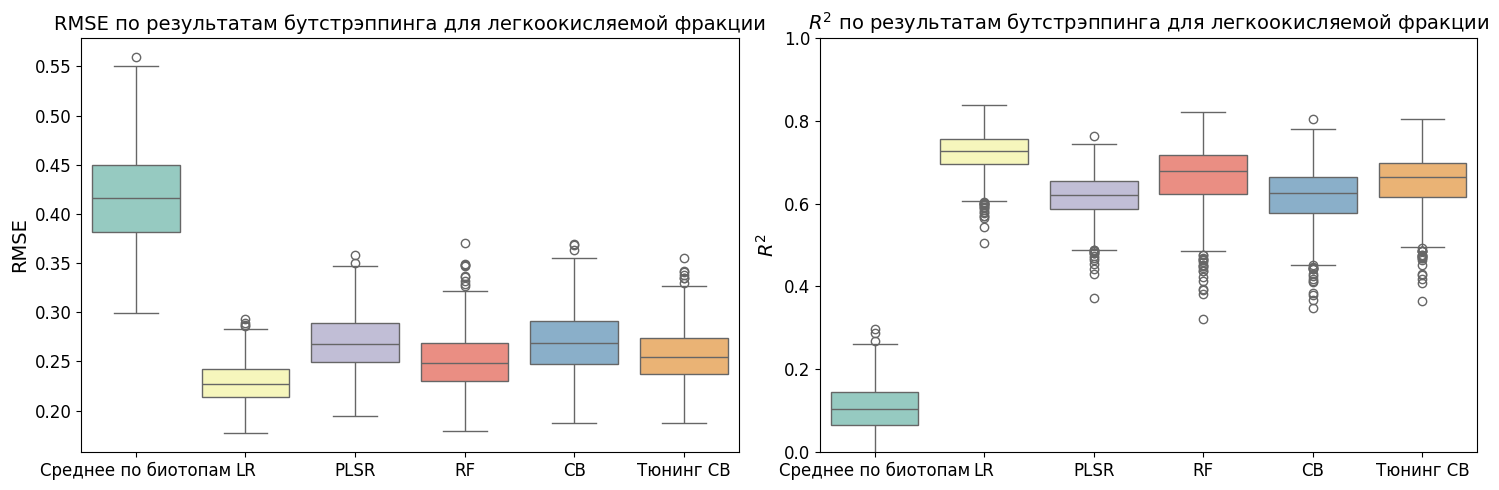

Fitting LR
Fitting PLSR
Fitting RF
Fitting CB
Fitting Тюнинг CB
0:	learn: 0.5975887	total: 1.2ms	remaining: 1.56s
500:	learn: 0.1862075	total: 567ms	remaining: 905ms
1000:	learn: 0.1161659	total: 1.15s	remaining: 343ms
1299:	learn: 0.0896494	total: 1.5s	remaining: 0us
Calculating bootstrap score for Cреднее по биотопам
Calculating bootstrap score for LR
Calculating bootstrap score for PLSR
Calculating bootstrap score for RF
Calculating bootstrap score for CB
Calculating bootstrap score for Тюнинг CB


<ipython-input-50-5035c0af3332>:154: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='model', y='mse', data=results_mse, ax=axes[0], palette="Set3")
<ipython-input-50-5035c0af3332>:160: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='model', y='r2', data=results_r2, ax=axes[1], palette="Set3")


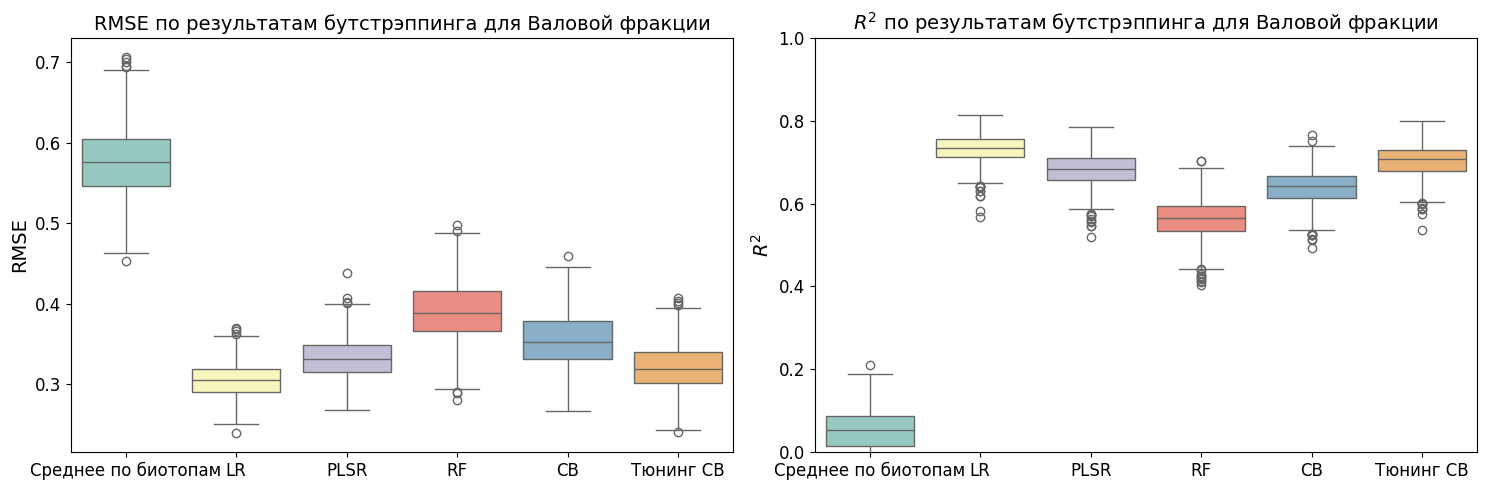

In [50]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

df = pd.read_excel('/content/drive/MyDrive/Tokarevka_data/Fieldpoints.xlsx')
df = df.drop('rand_point', axis=1).dropna()

years_to_drop = ['2019', '2020', '2021', '2022', '2023']
df = df.drop(columns=[col for col in df.columns if any(year in col for year in years_to_drop)])
x = df.drop(['hard', 'med', 'easy', 'hard_sh', 'med_sh', 'easy_sh', 'sum'], axis=1).dropna()

q1 = df['TPI10m_1'].quantile(0.25)
q3 = df['TPI10m_1'].quantile(0.75)

x['Biotopes_s'] = df['Biotopes_s'].astype('category').cat.codes

def print_metrics(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    return rmse, r2

def bootstrap_metric(y_true, y_pred, n_iterations=10000, sample_size=None, random_seed=42):
    if sample_size is None:
        sample_size = len(y_true)
    np.random.seed(random_seed)
    rmse_scores = []
    r2_scores = []
    rpiq_scores = []
    y_true_np = np.array(y_true)
    y_pred_np = np.array(y_pred)
    q1 = np.percentile(y_true_np, 25)
    q3 = np.percentile(y_true_np, 75)
    iqr = q3 - q1

    for _ in range(n_iterations):
        indices = np.random.choice(len(y_true_np), size=sample_size, replace=True)
        y_true_sample = y_true_np[indices]
        y_pred_sample = y_pred_np[indices]
        mse = mean_squared_error(y_true_sample, y_pred_sample)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_true_sample, y_pred_sample)
        rpiq = iqr / rmse
        rmse_scores.append(rmse)
        r2_scores.append(r2)
        rpiq_scores.append(rpiq)
    return rmse_scores, r2_scores, rpiq_scores

def train_and_test_regressor(models, x_train, y_train, x_test, y_test, x_train_biotope, x_test_biotope):
    for name, model in models.items():
        if name != "Cреднее по биотопам":
            print(f"Fitting {name}")
            model.fit(x_train, y_train)
    predictions = {}
    for name, model in models.items():
        if name == "Cреднее по биотопам":
            biotope_means = y_train.groupby(x_train_biotope).mean()
            y_pred = x_test_biotope.map(biotope_means).values
        else:
            y_pred = model.predict(x_test)
        predictions[name] = y_pred

    boot_scores_mse = {}
    boot_scores_r2 = {}
    boot_scores_rpiq = {}

    for name, y_pred in predictions.items():
        print(f"Calculating bootstrap score for {name}")
        mse_scores, r2_scores, rpiq_scores = bootstrap_metric(y_test, y_pred)
        boot_scores_mse[name] = mse_scores
        boot_scores_r2[name] = r2_scores
        boot_scores_rpiq[name] = rpiq_scores

    results_mse = pd.DataFrame(boot_scores_mse)
    results_r2 = pd.DataFrame(boot_scores_r2)
    results_rpiq = pd.DataFrame(boot_scores_rpiq)

    results_mse = results_mse.melt(value_vars=results_mse.columns, value_name="mse", var_name="model")
    results_r2 = results_r2.melt(value_vars=results_r2.columns, value_name="r2", var_name="model")
    results_rpiq = results_rpiq.melt(value_vars=results_rpiq.columns, value_name="rpiq", var_name="model")
    return results_mse, results_r2, results_rpiq

models = {
    "Cреднее по биотопам": None,
    "LR": LinearRegression(),
    "PLSR": PLSRegression(n_components=2),
    "RF": RandomForestRegressor(n_estimators=500, n_jobs=-1),
    "CB": CatBoostRegressor(verbose=0),
    "Тюнинг CB": CatBoostRegressor(
        iterations=1300,
        learning_rate=0.03,
        depth=3,
        l2_leaf_reg=4,
        random_seed=42,
        verbose=500
    ),
}

rus = {'hard':'трудноокисляемой', 'med':'среднеокисляемой', 'easy':'легкоокисляемой', 'sum':'Валовой'}
for fraction in ['hard', 'med', 'easy', 'sum']:
    y = df[fraction]
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

    scaler = StandardScaler()
    x_train_biotope = X_train['Biotopes_s']
    x_test_biotope = X_test['Biotopes_s']

    X_train = X_train.drop(columns=['Biotopes_s'])
    X_test = X_test.drop(columns=['Biotopes_s'])

    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    results_mse, results_r2, results_rpiq = train_and_test_regressor(models, X_train_scaled, y_train, X_test_scaled, y_test, x_train_biotope, x_test_biotope)

    sns.boxplot(x='model', y='mse', data=results_mse, ax=axes[0], palette="Set3")
    axes[0].set_title(f"RMSE по результатам бутстрэппинга для {rus[fraction]} фракции")
    axes[0].set_ylabel("RMSE")
    axes[0].set_xlabel("")

    sns.boxplot(x='model', y='r2', data=results_r2, ax=axes[1], palette="Set3")
    axes[1].set_title(f"$R^2$ по результатам бутстрэппинга для {rus[fraction]} фракции")
    axes[1].set_ylabel("$R^2$")
    axes[1].set_xlabel("")
    axes[1].set_ylim(0, 1)

    plt.tight_layout()
    plt.show()

## Retrieve metrics after bootstrapping for uncertainty analyiss

In [ ]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from joblib import Parallel, delayed

df = pd.read_excel('C:\\Users\\pihchikk\\Desktop\\Science\\Tokarevka\\Fieldpoints.xlsx')
df = df.drop('rand_point', axis=1).dropna()

years_to_drop = ['2019', '2020', '2021', '2022', '2023']
df = df.drop(columns=[col for col in df.columns if any(year in col for year in years_to_drop)])
df = df.drop(columns=['SOS21daily','SOS21_1','EOS21_1','SprPPI1_PP','PPI_aut1_P'])

x = df.drop(['hard', 'med', 'easy', 'hard_sh', 'med_sh', 'easy_sh', 'sum'], axis=1).dropna()

x['Biotopes_s'] = df['Biotopes_s'].astype('category').cat.codes

def calculate_metrics(y_true, y_pred):
    y_true = y_true.squeeze()
    y_pred = y_pred.squeeze()
    mse = (y_true - y_pred) ** 2
    rmse = np.sqrt(mse)
    r2 = 1 - (mse / np.var(y_true))
    q1 = np.percentile(y_true, 25)
    q3 = np.percentile(y_true, 75)
    iqr = q3 - q1
    rpiq = iqr / rmse
    return mse, rmse, r2, rpiq

def bootstrap_predictions(model, X, y, n_iterations=50, random_seed=42, n_jobs=-1):
    np.random.seed(random_seed)
    def fit_and_predict(indices):
        X_boot, y_boot = X[indices], y[indices]
        model.fit(X_boot, y_boot)
        return model.predict(X).squeeze()

    results = Parallel(n_jobs=n_jobs)(delayed(fit_and_predict)(np.random.choice(len(y), size=len(y), replace=True)) for _ in tqdm(range(n_iterations), desc='Bootstrapping'))
    return np.array(results)


def cross_val_metrics(models, x, y, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    results = []

    for name, model in models.items():
        print(f"Evaluating {name}")
        y_pred = cross_val_predict(model, x, y, cv=kf, n_jobs=-1)
        mse, rmse, r2, rpiq = calculate_metrics(y, y_pred)

        boot_preds = bootstrap_predictions(model, x, y)
        boot_mean = np.mean(boot_preds, axis=0)
        boot_var = np.var(boot_preds, axis=0)

        var_all = boot_var + mse

        z = 1.96  # For a 95% confidence interval
        se = np.sqrt(var_all) * z

        upl = boot_mean + se
        lpl = boot_mean - se
        pir = upl - lpl

        for i in range(len(y)):
            results.append({
                'model': name, 'index': i, 'rmse': rmse[i], 'r2': r2[i], 'rpiq': rpiq[i],
                'pred': y_pred[i], 'upl': upl[i], 'lpl': lpl[i], 'pir': pir[i]
            })

    results_df = pd.DataFrame(results)
    return results_df

models = {
    "CatBoost": CatBoostRegressor(verbose=0),
    "TunedCatBoost2": CatBoostRegressor(
        iterations=1300,
        learning_rate=0.03,
        depth=3,
        l2_leaf_reg=4,
        random_seed=42,
        verbose=500
    ),
    "LinearRegression": LinearRegression(),
    "RandomForestRegressor": RandomForestRegressor(n_estimators=500, n_jobs=-1),
    "PLSR": PLSRegression(n_components=2)
}

def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

df_with_metrics = df.copy()

for fraction in ['hard', 'med', 'easy', 'sum']:
    y = df[fraction]

    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(x)

    fig, axes = plt.subplots(1, 3, figsize=(30, 5))

    results_df = cross_val_metrics(models, x_scaled, y, n_splits=5)

    for name in models.keys():
        model_results = results_df[results_df['model'] == name]
        df_with_metrics[f'{fraction}_{name}_rmse'] = model_results['rmse'].values
        df_with_metrics[f'{fraction}_{name}_r2'] = model_results['r2'].values
        df_with_metrics[f'{fraction}_{name}_rpiq'] = model_results['rpiq'].values
        df_with_metrics[f'{fraction}_{name}_pred'] = model_results['pred'].values
        df_with_metrics[f'{fraction}_{name}_upl'] = model_results['upl'].values
        df_with_metrics[f'{fraction}_{name}_lpl'] = model_results['lpl'].values
        df_with_metrics[f'{fraction}_{name}_pir'] = model_results['pir'].values

    results_rmse = remove_outliers(results_df, 'rmse')
    results_r2 = remove_outliers(results_df, 'r2')
    results_rpiq = remove_outliers(results_df, 'rpiq')

    sns.boxplot(x='model', y='rmse', data=results_rmse, ax=axes[0], palette="Set3")
    axes[0].set_title(f"Cross-Validated RMSE for {fraction} Fraction")
    axes[0].set_ylabel("RMSE")
    axes[0].set_xlabel("")

    sns.boxplot(x='model', y='r2', data=results_r2, ax=axes[1], palette="Set3")
    axes[1].set_title(f"Cross-Validated R2 for {fraction} Fraction")
    axes[1].set_ylabel("R2")
    axes[1].set_xlabel("")
    axes[1].set_ylim(0, 1)

    sns.boxplot(x='model', y='rpiq', data=results_rpiq, ax=axes[2], palette="Set3")
    axes[2].set_title(f"Cross-Validated RPIQ for {fraction} Fraction")
    axes[2].set_ylabel("RPIQ")
    axes[2].set_xlabel("")

    plt.tight_layout()
    plt.suptitle(f'Cross-Validated RMSE, R2, and RPIQ for {fraction} Fraction', y=1.05, fontsize=16)
    plt.show()

#df_with_metrics.to_excel('')